# Hotel Prediction with Hybrid Collaborative Filtering with SVD
### D. Akman

# Table of Contents

1. [Introduction and Methodology](#Introduction-and-Methodology)
    - [Methodology](#Methodology)
    - [Limitations](#Limitations)
    - [Requirements](#Requirements)
2. [Exploratory Data Analysis](#Exploratory-Data-Analysis)
    - [Preliminaries](#Preliminaries)
    - [Data Preprocessing](#Data-Preprocessing)
    - [Data Summarisation](#Data-Summarisation)
        - [Gender](#Gender)
        - [Home Continent](#Home-Continent)
        - [Hotel Star Ratings](#Hotel-Star-Ratings)
    - [Data Visualisation](#Data-Visualisation)
        - [Distribution of Users by Gender](#Distribution-of-Users-by-Gender)
        - [Distribution of Users by Home Continent](#Distribution-of-Users-by-Home-Continent)
        - [Distribution of Hotel Star Ratings](#Distribution-of-Hotel-Star-Ratings)
3. [Collaborative Filtering (CF) Modelling](#Collaborative-Filtering-Modelling)
    - [Similarity Score Calculations](#Similarity-Score-Calculations)
    - [Finding the Most Similar User](#Finding-the-Most-Similar-User)
    - [Hotel Prediction](#Hotel-Prediction)
    - [Saving Results](#Saving-Results)

## 1. Introduction and Methodology

In this mini study, we will predict the next hotel a user will view using a Hybrid Collaborative Filtering approach.

The information given to us are as follows:
- **User demographic information:** user no, home continent, gender
- **Hotel information:** hotel no, star rating
- **Activity information:** browsing history of each user (user no, hotel no) 

We will model this problem as a *recommender system problem*, as our goal is to identify the "next most likely hotel" that the user will look at, which can in fact be considered analogous to the "next item to show" problem, as on a marketplace like Amazon.

The user-hotel information is similar to user-item interaction data in a typical recommender system. For this reason, we will resort to a `Hybrid User-Based Collaborative Filtering (CF)` approach for this problem. The User-Based CF method leverages the behaviour of similar users to make predictions. It is effective for recommendation systems like the one at hand because it identifies patterns in user behaviour. User-based collaborative filtering focuses on understanding what each user likes and recommends items that similar users have liked. This is beneficial for making personalised recommendations based on user behaviour and preferences.

For the `Hybrid` implementation, we adopt `Feature Augmentation` method: augment the user-hotel interaction matrix with demographic information, essentially adding more dimensions to the similarity computation. Specifically, we combine user hotel view features with user demographic information of home continent and gender. In our implementation, we give twice as weight to demographic information compared to the hotel view preferences, though this would need to be fine-tuned in practice to get the optimal cross-validated prediction performance. 

We also include an additional step for `Dimensionality Reduction Using SVD` in this notebook.

We choose Collaborative filtering over content-based filtering and popularity-based recommendations for this mini study due to its ability to balance personalisation and diversity effectively. While content-based filtering recommends items based on item features and is useful for new users, it requires detailed feature data (certainly more than just hotel ratings) and can lack recommendation diversity. Popularity-based recommendations are simple and effective for new users but provide generic, non-personalised suggestions. Collaborative filtering leverages user interaction data to capture complex preferences (since we do have activity information) and offers diverse recommendations by considering similar users' behaviours, making it a good choice for this particular use case.


### Methodology
Our approach can be summarised as follows:
- Perform dummy-encoding of the gender feature and one-hot-encoding of the home continent feature.
- Construct the hybrid interaction matrix consisting of user hotel views combined with user demographic information where we give more weight to the latter.
- Use SVD for dimensionality reduction for better performance, though this hasn't been tuned.
- Calculate the hybrid user similarity scores matrix using cosine similarity.
- When calculating similarity, take into account the user's home continent, hotels browsed, and the user's gender.
- To predict next hotel browsing for a given user,
> - Find the most similar user to this given user as per the similarity matrix
> - Find the hotels viewed by the most similar user
> - Get the hotels viewed by the given user
> - Return a random hotel that the most similar user viewed that the given user has not viewed yet as the final prediction.
> - If such a hotel does not exist, we return the most common hotel for the given user's gender and continent.
> - Worst case scenario, we fall back on the most common hotel in the activity data.

### Limitations
Our approach doesn't consider the temporal aspect of the data, that is, the sequence in which hotels were viewed, as this information was not included in the files provided.

We haven't done any benchmarking or comparisons to similar recommender systems. In addition, a better approach would include a validation step to evaluate the prediction accuracy on a hold-out set with a train-test splitting to ensure we are not overfitting.


### Requirements
You will need Python >= 3.10 and the following modules for this code to work:

matplotlib==3.9.1 <br>
numpy==2.0.0 <br>
pandas==2.2.2 <br>
scikit_learn==1.5.1 <br>
seaborn==0.13.2 <br>

## 2. Exploratory Data Analysis

### 2(A) - Preliminaries

In this section, we load up the three individual datasets and do dummy encoding as needed. We take into account that home continent and gender are nominal categorical features.

We merge them into a single dataset that we will use in the rest of the analysis.

In [1]:
import pandas as pd
import numpy as np

# so that we can see all the columns and rows
# pd.set_option('display.max_columns', None) 
# pd.set_option('display.max_rows', None) 

users_raw = pd.read_csv("users.txt", sep="\t")
activity = pd.read_csv("activity.txt", sep="\t")
hotels = pd.read_csv("hotels.txt", sep="\t")

In [2]:
users_raw.head()

,user,home_continent,gender
0,1,2,female
1,2,3,female
2,3,1,male
3,4,2,female
4,5,2,male


In [3]:
hotels.head()

,hotel,star_rating
0,1,3.0
1,2,2.0
2,3,3.5
3,4,4.0
4,5,4.0


In [4]:
activity.head()

,user,hotel
0,1,39
1,1,44
2,2,63
3,2,2
4,3,26


### 2(B) - Data Preprocessing
Let's make sure these data frames do not have any duplicate rows. We notice that activity has one duplicate row, which we drop.

In [5]:
print(f"{users_raw.shape = }")
print(f"{hotels.shape = }")
print(f"{activity.shape = }")

users_raw.shape = (4544, 3)
hotels.shape = (66, 2)
activity.shape = (17230, 2)


In [6]:
users_raw = users_raw.drop_duplicates()
hotels = hotels.drop_duplicates()
activity = activity.drop_duplicates()

In [7]:
print(f"{users_raw.shape = }")
print(f"{hotels.shape = }")
print(f"{activity.shape = }")

users_raw.shape = (4544, 3)
hotels.shape = (66, 2)
activity.shape = (17229, 2)


In [8]:
# "user" is "users_raw" with gender and continent encoded:

users = users_raw.copy()

users['gender'] = users_raw['gender'].map({'male': 0, 'female': 1})

users = pd.get_dummies(users, columns=["home_continent"])
users = users.astype(int)

users.head()

,user,gender,home_continent_1,home_continent_2,home_continent_3,home_continent_4,home_continent_5,home_continent_6,home_continent_7
0,1,1,0,1,0,0,0,0,0
1,2,1,0,0,1,0,0,0,0
2,3,0,1,0,0,0,0,0,0
3,4,1,0,1,0,0,0,0,0
4,5,0,0,1,0,0,0,0,0


In [9]:
activity_users = pd.merge(activity, users, on='user')

data = pd.merge(activity_users, hotels, on='hotel')

print(f"{data.shape = }")

# data.to_csv("data.csv", index=False)

# let's have a look at what the combined activity data looks like
data.head()

data.shape = (17229, 11)


,user,hotel,gender,home_continent_1,home_continent_2,home_continent_3,home_continent_4,home_continent_5,home_continent_6,home_continent_7,star_rating
0,1,39,1,0,1,0,0,0,0,0,4.0
1,1,44,1,0,1,0,0,0,0,0,3.0
2,2,63,1,0,0,1,0,0,0,0,4.5
3,2,2,1,0,0,1,0,0,0,0,2.0
4,3,26,0,1,0,0,0,0,0,0,4.0


Let's have a look at unique value counts for each feature in our dataset.

We observe that we have a total of 7 continents, 66 hotels, and 4,544 users with 17,229 unique user activities.

In [10]:
data.nunique()

user                4544
hotel                 66
gender                 2
home_continent_1       2
home_continent_2       2
home_continent_3       2
home_continent_4       2
home_continent_5       2
home_continent_6       2
home_continent_7       2
star_rating            7
dtype: int64

### 2(C) - Data Summarisation

In this section, we perform some data summarisation to get a better sense of how our data looks like numerically.

In particular, we have a look at the following distributions as percentages:
- Gender Distribution 
- Home Continent Distribution
- Hotel Star Ratings Distribution

#### Gender

In [11]:
users_raw["gender"].value_counts(normalize=True).mul(100).round(2)

gender
male      54.16
female    45.84
Name: proportion, dtype: float64

#### Home Continent

In [12]:
users_raw["home_continent"].value_counts(normalize=True).mul(100).round(2)

home_continent
2    74.10
1    16.15
3     3.50
4     2.86
5     2.29
7     0.77
6     0.33
Name: proportion, dtype: float64

#### Hotel Star Ratings

In [13]:
hotels["star_rating"].value_counts(normalize=True).mul(100).round(2)

star_rating
4.0    30.30
3.0    18.18
3.5    16.67
4.5    10.61
2.0     9.09
2.5     9.09
5.0     6.06
Name: proportion, dtype: float64

### 2(D) - Data Visualisation

In this section, we perform some data visualisation to get a better sense of how our data looks like visually.

In particular, we generate the following three plots:
- Distribution of users by gender
- Distribution of users by home continent
- Distribution of hotel star ratings


In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

%matplotlib inline 
%config InlineBackend.figure_format = 'retina'

plt.style.use("seaborn-v0_8")

#### Distribution of Users by Gender

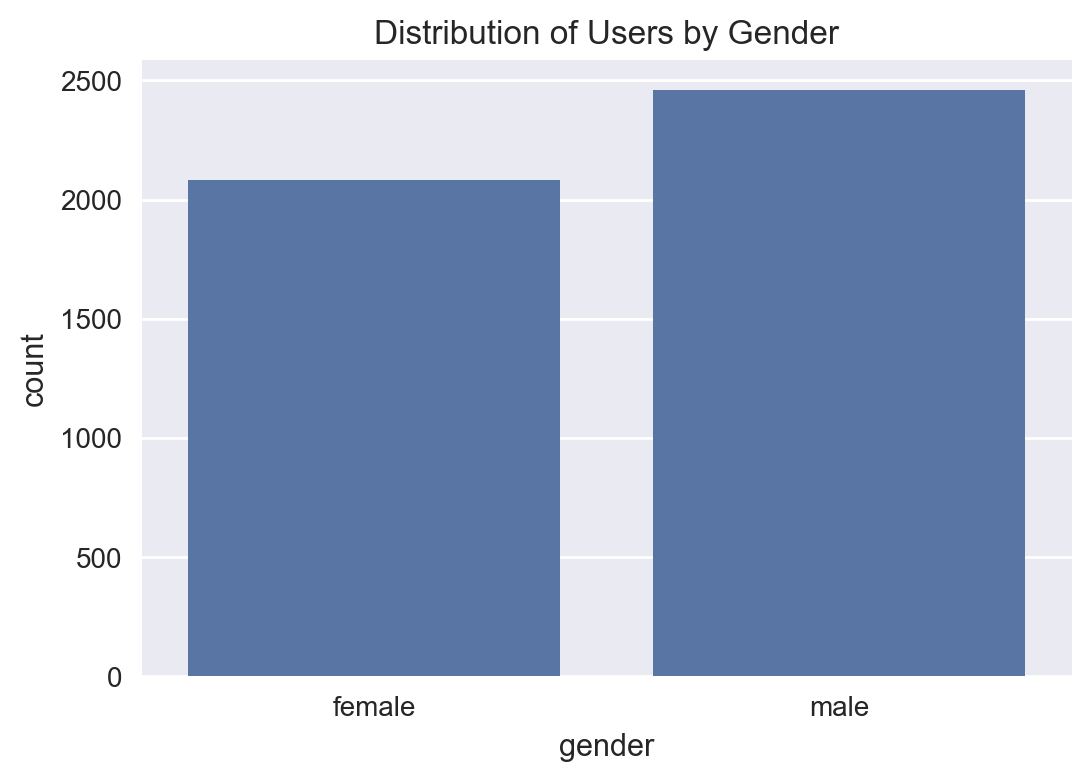

In [15]:
plt.figure(figsize=(6, 4)) 
sns.countplot(x='gender', data=users_raw)
plt.title('Distribution of Users by Gender')
plt.show()

#### Distribution of Users by Home Continent

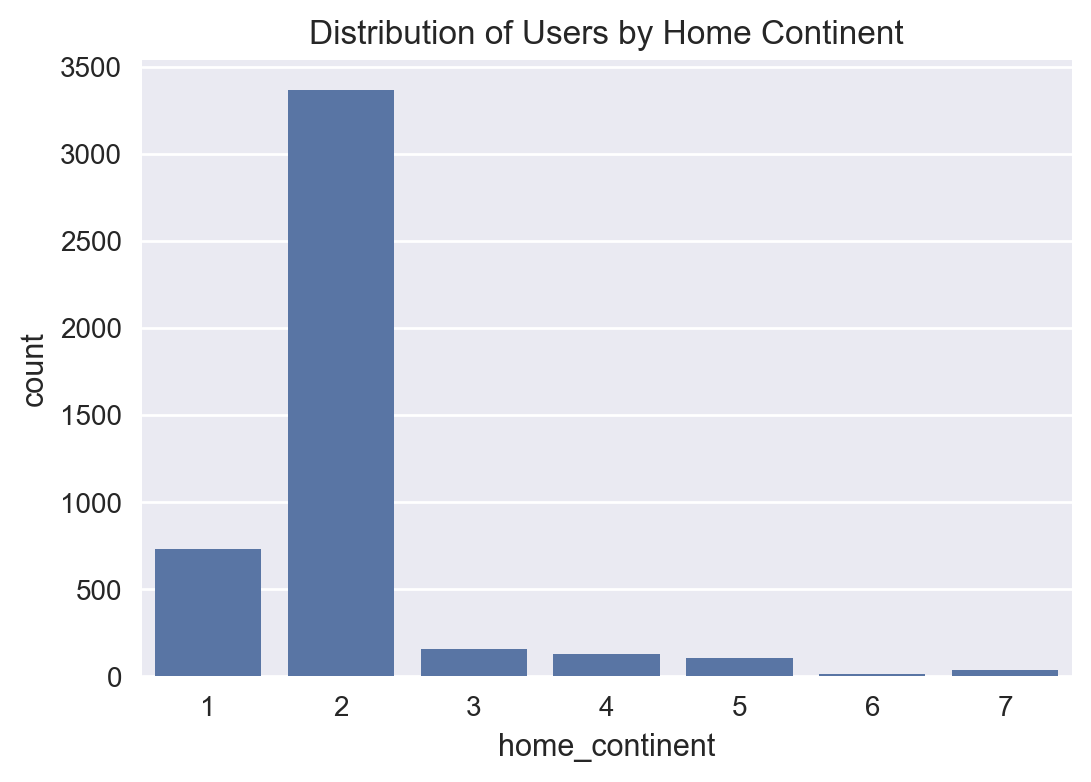

In [16]:
# distribution of users by home continent
plt.figure(figsize=(6, 4)) 
sns.countplot(x='home_continent', data=users_raw)
plt.title('Distribution of Users by Home Continent')
plt.show()

#### Distribution of Hotel Star Ratings

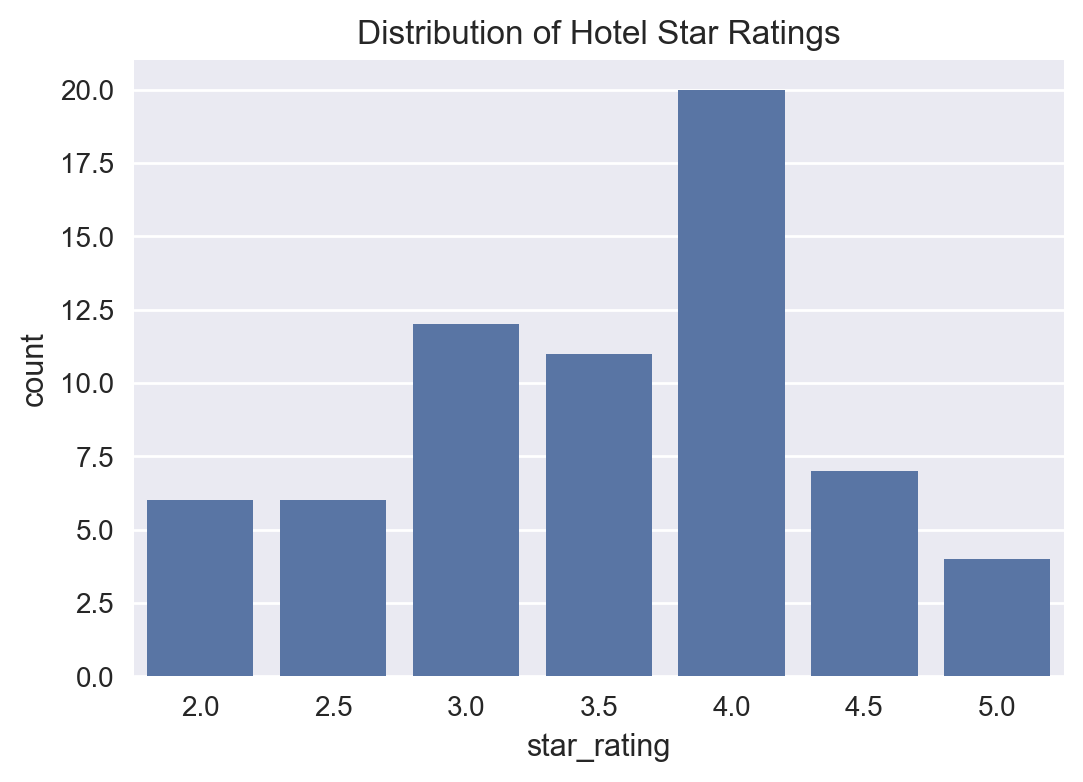

In [17]:
# distribution of star ratings
plt.figure(figsize=(6, 4)) 
sns.countplot(x='star_rating', data=hotels)
plt.title('Distribution of Hotel Star Ratings')
plt.show()

## 3. Collaborative Filtering (CF) Modelling

### 3(A) - Similarity Score Calculations

We now construct our augmented CF interaction matrix, which is essentially a user-hotel matrix with the cell values being the hotels' star ratings augmented by the binary features indicating home continents and gender.

Next, we compute our user similarity matrix, which has the following:
- One row and one column for each user.
- Cell values for these rows and columns are the cosine similarity score between these two users.

#### Scaling Star Ratings

We will normalise the hotel star ratings between 0 and 0.5 so that they do not dominate in the similarity calculations. That is, we would like to give more weight to home continents and gender in similarity compared to users' hotel preferences.

In practice, this max scaling value would need to be fine-tuned for optimal cross-validated prediction performance.

In [18]:
# data = pd.merge(activity_users, hotels, on='hotel')

data.head()

,user,hotel,gender,home_continent_1,home_continent_2,home_continent_3,home_continent_4,home_continent_5,home_continent_6,home_continent_7,star_rating
0,1,39,1,0,1,0,0,0,0,0,4.0
1,1,44,1,0,1,0,0,0,0,0,3.0
2,2,63,1,0,0,1,0,0,0,0,4.5
3,2,2,1,0,0,1,0,0,0,0,2.0
4,3,26,0,1,0,0,0,0,0,0,4.0


In [19]:
from sklearn import preprocessing

hotel_ratings_max_value = 0.5

scaler = preprocessing.MinMaxScaler(feature_range=(0, hotel_ratings_max_value))

data["star_rating"] = scaler.fit_transform(data["star_rating"].values.reshape(-1, 1)).ravel()

data.head()

,user,hotel,gender,home_continent_1,home_continent_2,home_continent_3,home_continent_4,home_continent_5,home_continent_6,home_continent_7,star_rating
0,1,39,1,0,1,0,0,0,0,0,0.333333
1,1,44,1,0,1,0,0,0,0,0,0.166667
2,2,63,1,0,0,1,0,0,0,0,0.416667
3,2,2,1,0,0,1,0,0,0,0,0.000000
4,3,26,0,1,0,0,0,0,0,0,0.333333


#### Augmented Interaction Matrix

In [20]:
interaction_matrix = data.pivot_table(index='user', 
                                    columns='hotel', 
                                    values='star_rating', 
                                    fill_value=0)

# flatten the MultiIndex columns
interaction_matrix.columns = [str(col) for col in interaction_matrix.columns]

interaction_matrix = interaction_matrix.reset_index()

user_info = data[['user', 'gender', 'home_continent_1', 'home_continent_2', 'home_continent_3', 
                  'home_continent_4', 'home_continent_5', 'home_continent_6', 'home_continent_7']]

user_info = user_info.drop_duplicates().set_index('user')

interaction_matrix = interaction_matrix.merge(user_info, left_on='user', right_index=True)

In [21]:
interaction_matrix

,user,1,2,3,4,5,6,7,8,9,...,65,66,gender,home_continent_1,home_continent_2,home_continent_3,home_continent_4,home_continent_5,home_continent_6,home_continent_7
0,1,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1,0,1,0,0,0,0,0
1,2,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1,0,0,1,0,0,0,0
2,3,0.000000,0.0,0.00,0.333333,0.0,0.0,0.333333,0.0,0.0,...,0.0,0.0,0,1,0,0,0,0,0,0
3,4,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1,0,1,0,0,0,0,0
4,5,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0,0,1,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,4540,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0,0,1,0,0,0,0,0
4540,4541,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1,0,1,0,0,0,0,0
4541,4542,0.000000,0.0,0.25,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,0,0,1,0,0,0,0,0
4542,4543,0.000000,0.0,0.00,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.0,1,1,0,0,0,0,0,0


#### User Similarity Matrix

In [22]:
from sklearn.metrics.pairwise import cosine_similarity

user_similarity = cosine_similarity(interaction_matrix)

user_sim_df = pd.DataFrame(user_similarity, 
                           index=interaction_matrix.user, 
                           columns=interaction_matrix.user)

# flatten the MultiIndex columns
user_sim_df.columns = [str(col) for col in user_sim_df.columns]

user_sim_df = user_sim_df.reset_index()

Let's have a look at the user similarity matrix. We note that all column names are strings at this point.

In [23]:
user_sim_df

,user,1,2,3,4,5,6,7,8,9,...,4535,4536,4537,4538,4539,4540,4541,4542,4543,4544
0,1,1.000000,0.681497,0.507039,0.790639,0.660210,0.727470,0.636992,0.624209,0.618485,...,0.564557,0.564557,0.564433,0.564681,0.564433,0.564571,0.564681,0.564557,0.564571,0.564571
1,2,0.681497,1.000000,0.744009,0.861957,0.784602,0.842921,0.794859,0.840726,0.837918,...,0.804934,0.804934,0.804934,0.805023,0.804934,0.804934,0.805023,0.804934,0.805023,0.805111
2,3,0.507039,0.744009,1.000000,0.863163,0.875626,0.880409,0.887074,0.883070,0.918721,...,0.898325,0.898334,0.898383,0.898317,0.898400,0.898317,0.898334,0.898317,0.898383,0.898317
3,4,0.790639,0.861957,0.863163,1.000000,0.955769,0.977915,0.955091,0.946682,0.946529,...,0.933897,0.933897,0.933845,0.933948,0.933845,0.933896,0.933948,0.933896,0.933896,0.933896
4,5,0.660210,0.784602,0.875626,0.955769,1.000000,0.973629,0.990805,0.960858,0.961278,...,0.974788,0.974783,0.974740,0.974793,0.974740,0.974783,0.974788,0.974793,0.974740,0.974740
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,4540,0.564571,0.804934,0.898317,0.933896,0.974783,0.966674,0.987515,0.983027,0.986188,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4540,4541,0.564681,0.805023,0.898334,0.933948,0.974788,0.966719,0.987515,0.983054,0.986212,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4541,4542,0.564557,0.804934,0.898317,0.933896,0.974793,0.966678,0.987515,0.983030,0.986188,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4542,4543,0.564571,0.805023,0.898383,0.933896,0.974740,0.966674,0.987484,0.983054,0.986236,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### Dimensionality Reduction Using SVD

We can apply some dimensionality reduction using Singular Value Decomposition (SVD) on the interaction matrix. This would help with managing sparsity and improving both computational efficiency and generalisation of our hybrid recommender system. 

In [24]:
from sklearn.decomposition import TruncatedSVD

interaction_matrix_svd = interaction_matrix.copy()

interaction_matrix_svd.columns = interaction_matrix_svd.columns.astype(str)

# needs to be fine-tuned
n_components=10

# SVD for dimensionality reduction
svd = TruncatedSVD(n_components=n_components)
user_similarity_svd = svd.fit_transform(interaction_matrix_svd)

print(f"{user_similarity_svd.shape = }")

# Compute similarity matrix
user_sim_df_svd = cosine_similarity(user_similarity_svd)
user_sim_df_svd = pd.DataFrame(user_sim_df_svd, columns=user_sim_df.reset_index(drop=True).drop(columns=["user"]).columns)
user_sim_df_svd["user"] = user_sim_df["user"]

# move the user column to front
cols = user_sim_df_svd.columns.tolist()
user_sim_df_svd = user_sim_df_svd[[cols[-1]] + cols[:-1]]

# assign back to the original sim matrix
user_sim_df = user_sim_df_svd.copy()

user_similarity_svd.shape = (4544, 10)


In [25]:
user_sim_df

,user,1,2,3,4,5,6,7,8,9,...,4535,4536,4537,4538,4539,4540,4541,4542,4543,4544
0,1,1.000000,0.705265,0.538470,0.811823,0.673686,0.742210,0.650841,0.636528,0.629243,...,0.573656,0.573656,0.573532,0.573780,0.573528,0.573661,0.573781,0.573655,0.573660,0.573664
1,2,0.705265,1.000000,0.766869,0.867956,0.798736,0.858946,0.809284,0.853157,0.851640,...,0.817649,0.817651,0.817649,0.817740,0.817648,0.817651,0.817739,0.817649,0.817740,0.817833
2,3,0.538470,0.766869,1.000000,0.880602,0.910725,0.910937,0.919034,0.914367,0.950835,...,0.926548,0.926569,0.926619,0.926551,0.926635,0.926550,0.926565,0.926549,0.926618,0.926553
3,4,0.811823,0.867956,0.880602,1.000000,0.969133,0.988826,0.966186,0.956756,0.956323,...,0.941887,0.941889,0.941836,0.941940,0.941836,0.941888,0.941939,0.941887,0.941887,0.941889
4,5,0.673686,0.798736,0.910725,0.969133,1.000000,0.981832,0.996856,0.964957,0.967641,...,0.979033,0.979029,0.978986,0.979036,0.978985,0.979028,0.979029,0.979035,0.978985,0.978985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4539,4540,0.573661,0.817651,0.926550,0.941888,0.979028,0.968943,0.989868,0.984987,0.987960,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4540,4541,0.573781,0.817739,0.926565,0.941939,0.979029,0.968989,0.989867,0.985013,0.987984,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4541,4542,0.573655,0.817649,0.926549,0.941887,0.979035,0.968948,0.989868,0.984988,0.987961,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000
4542,4543,0.573660,0.817740,0.926618,0.941887,0.978985,0.968943,0.989837,0.985014,0.988008,...,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000


### 3(B) - Finding the Most Similar User

Now, let's define a function to get the most similar user to a given user using the similarity matrix.

In [26]:
def get_most_similar_user(user, data, user_sim_df):

    # get the given user row in the similarity matrix
    df_sim_row = user_sim_df.loc[user_sim_df["user"] == user]
    
    series_sim_row = df_sim_row.iloc[0]
    
    # sort the similarity scores in descending order
    sorted_series = series_sim_row.sort_values(ascending=False)

    # get the index of the third largest element
    # the first one will be user no, the second one will be 1.00
    # so we want the THIRD one in the series
    most_similar_user = sorted_series.index[2]

    return int(most_similar_user)

In [27]:
# case study:
my_user = 1

most_similar_user = get_most_similar_user(my_user, data, user_sim_df)

print(f"\nOur model predicts that user no {my_user}'s most similar user is {most_similar_user}.")


Our model predicts that user no 1's most similar user is 4.


In [28]:
# let's do some sanity check!

data2 = data[data["user"].isin([my_user, most_similar_user])]
data2

,user,hotel,gender,home_continent_1,home_continent_2,home_continent_3,home_continent_4,home_continent_5,home_continent_6,home_continent_7,star_rating
0,1,39,1,0,1,0,0,0,0,0,0.333333
1,1,44,1,0,1,0,0,0,0,0,0.166667
12,4,63,1,0,1,0,0,0,0,0,0.416667
13,4,52,1,0,1,0,0,0,0,0,0.416667


### 3(C) - Hotel Prediction

Now we can predict the next hotel for the given user using CF.

In [29]:
# get the most popular hotel for a final fallback
def most_popular_hotel():
    popular_hotels = activity['hotel'].value_counts()
    return popular_hotels.index[0]

In [30]:
# get the most popular hotel within the same demographic group
def demog_based_hotel(user):
    
    user_info = users_raw[users_raw['user'] == user]
    
    if user_info.empty:
        # fallback to global most popular hotel if user is not found
        return most_popular_hotel()
    
    home_continent = user_info['home_continent'].values[0]
    gender = user_info['gender'].values[0]
    
    # activity of users with the same continent and gender
    demog_users = users_raw[(users_raw['home_continent'] == home_continent) & (users_raw['gender'] == gender)]
    demog_activity = activity[activity['user'].isin(demog_users['user'])]
    
    if demog_activity.empty:
        # fallback to most popular hotel if no demographic data is available
        return most_popular_hotel()
    
    # get the most popular hotel within this demographic group
    popular_hotels = demog_activity['hotel'].value_counts()
    
    return popular_hotels.index[0]

In [31]:
def predict_next_hotel(user, user_sim_df, data):

    most_similar_user = get_most_similar_user(user, data, user_sim_df)
    
    # hotels viewed by the most similar user
    similar_user_hotels = data[data["user"] == most_similar_user]["hotel"].values
    
    # hotels viewed by the given user
    user_hotels = data[data["user"] == user]["hotel"].values
    
    # the first hotel (after sorting by hotel no to simulate random hotel selection) 
    # that the most similar user viewed which the given user has not viewed
    for hotel in similar_user_hotels:
        if hotel not in user_hotels:
            return hotel

    # testing:
    # fallback = most_popular_hotel()
    
    fallback = demog_based_hotel(user)
    
    return fallback

Let's have a look at the results for our mini case study. We see that our code correctly identifies the hotel to recommend.

In [32]:
# let's sort data by user and hotel no to simulate random hotel selection
data = data.sort_values(by=["user", "hotel"], ascending=[True, True])

next_hotel = predict_next_hotel(my_user, user_sim_df, data)

print(f"\nOur model predicts that user no {my_user}'s next hotel is {next_hotel}.")


Our model predicts that user no 1's next hotel is 52.


In [33]:
# confirmation from the similarity matrix
user_sim_df2 = user_sim_df[user_sim_df["user"].isin([my_user, most_similar_user])]

user_sim_df2

,user,1,2,3,4,5,6,7,8,9,...,4535,4536,4537,4538,4539,4540,4541,4542,4543,4544
0,1,1.000000,0.705265,0.538470,0.811823,0.673686,0.742210,0.650841,0.636528,0.629243,...,0.573656,0.573656,0.573532,0.57378,0.573528,0.573661,0.573781,0.573655,0.573660,0.573664
3,4,0.811823,0.867956,0.880602,1.000000,0.969133,0.988826,0.966186,0.956756,0.956323,...,0.941887,0.941889,0.941836,0.94194,0.941836,0.941888,0.941939,0.941887,0.941887,0.941889


### 3(D) - Saving Results
Now we are ready to save the entire set of predictions to a file.

In [34]:
predictions = list()

for user in sorted(data["user"].unique()):
    next_hotel = predict_next_hotel(int(user), user_sim_df, data)
    predictions.append((user, next_hotel))

predictions_df = pd.DataFrame(predictions, columns=['user', 'hotel'])

predictions_df.to_csv('dakman_predictions.tsv', sep='\t', index=False)

In [35]:
print("\n\nAll done !!! Thanks for this exercise! It was fun.\n\nKind Regards, - D. Akman.\n\n")



All done !!! Thanks for this exercise! It was fun.

Kind Regards, - D. Akman.




---